## Вариационный автоэнкодер для генерации предметов одежды схожих на датасет Fashion-MNIST

# Задание

__Создать 2 различные модели VAE и оценить качество генерации изображений предметов одежды. Построить картинку с плавными переходами между предметами благодаря семплированию из латентного пространства.__

Создададим 2 модели:
1.   Создадим вариационный автоэнкодер с использованием сверток ([Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)) в энкодере (слои отвечающие за среднее и отклонение остаются полносвязными), и с развертками ([Conv2dTranspose](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d) в декодере. Размерность скрытого вектора равна двум 

2.  Создадим вариационный автоэнкодер с использованием сверток (Conv2d) в энкодере (слои отвечающие за среднее и отклонение остаются полносвязными), и с развертками ([Upsample](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample), [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)) в декодере. Размерность скрытого вектора равна двум. [Подробнее](https://distill.pub/2016/deconv-checkerboard/) 

Для построения изображения постепенного перехода типов одежды необходимо создать сетку из N на N изображений, где по оси Х изменяется значение первого элемента **z**, а по оси Y - второго элемента **z**. Построим такие сетки для каждой построенной модели

In [44]:
import torch
import torch.nn as nn
import datetime as dt
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import torch.nn.functional as F

## 1 модель:

Загрузим данные:

In [45]:
BATCH_SIZE = 600  # размер батча

transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("len(train_dataset) =", len(train_dataset))

val_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("len(val_dataset) =", len(val_dataset))

len(train_dataset) = 60000
len(val_dataset) = 10000


Фотки Fashion-MNIST - чб размером 28 на 28 пикселей

Создадаим класс энкодера:

In [46]:
class FirstEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(FirstEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv1 = nn.Sequential(                                           
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=2, padding=1),      
             nn.BatchNorm2d(32),
             nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),          
             nn.BatchNorm2d(32),
             nn.ReLU())
            
        self.fc_mu = nn.Sequential(
            nn.Linear(32 * 49, self.latent_dim))
        
        self.fc_var = nn.Sequential(
            nn.Linear(32 * 49, self.latent_dim))


    def forward(self, x):
        x = self.conv1(x)
        x = x.reshape(-1, 32*49)
        mu = self.fc_mu(x)
        logvar = self.fc_var(x)
        return mu, logvar

Создадим класс декодера:

In [47]:
class FirstDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(FirstDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, 32*49),
          
        )
        self.conv1 = nn.Sequential(
           nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),       
           nn.BatchNorm2d(32),
              nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),     
        )

        self.dropout = nn.Dropout(0.5)       
        
        
    def forward(self, x):
        x = self.fc_decoder(x)
        x = x.reshape(-1,32,7,7)
        x = self.conv1(x)
        
        return x

Создадим класс VAE который внутри себя обращаться будет к двум другим классам FirstEncoder и FirstDecoder

In [48]:
class VAE(nn.Module):
        def __init__(self, latent_dim):
            super(VAE, self).__init__()
            self.latent_dim = latent_dim
            self.encoder = FirstEncoder(latent_dim)
            self.decoder = FirstDecoder(latent_dim)

        def forward(self, x):
            mu, logvar = self.encoder(x)
            z = self.reparametrize(mu, logvar)
            x_hat = self.decoder(z)
            return x_hat, mu, logvar
    
    # Функция выполняющая репараметризацию
        def reparametrize(self, mu, logvar):
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps * std + mu

    # Реализация рандомного семплирования из латентного пространства для визуализации
        def sample(self, num_samples) -> torch.Tensor:
            z = torch.randn(num_samples,
                            self.latent_dim)

            z = z.to(self.encoder.fc_mu[0].weight.device)

            samples = torch.sigmoid(self.decoder(z))

            return samples

Загрузим раcширение для tensorboard: 

In [49]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Результаты процесса обучения будем отображать в tensorboard среде. Так как GitHub не отображает расширение jupiter tensorboard, поэтому все результаты будут сохранены в tensorboard.dev и представлены в виде ссылки

[__РЕЗУЛЬТАТЫ  Fashion MNIST TensorBoard.dev__](https://tensorboard.dev/experiment/vlko1JGgReGLujNpGIkqDQ/#scalars&_smoothingWeight=0.855)



In [50]:
%reload_ext tensorboard
%tensorboard --logdir 'logs_fashion'

Reusing TensorBoard on port 6006 (pid 15288), started 3:44:59 ago. (Use '!kill 15288' to kill it.)

In [51]:
epochs = 200   # число эпох
latent_dim = 2   # Размер латентного простанства

# число рандомных семплов и латентного простанства для визуализации процесса обучения:
num_examples_to_generate = 16

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VAE(latent_dim).to(device)

# параметры градиентного спуска и scheduler для постепенного уменьшения величины шага
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5)

In [52]:
summary_writer = SummaryWriter(comment = ' With ConvTranspose in the decoder part')

    
def generate_and_save_images(model, epoch, file_writer):
    '''
    Генерирует 16 примеров и записывает их в file_writer для
    визуализации в tensorboard
    '''
    with torch.no_grad():
        model.eval()
        predictions = model.sample(16).reshape(-1,1,28,28)
    images = torchvision.utils.make_grid(predictions, 4)
    file_writer.add_image("samples", images, global_step=epoch)

    
# Получим результат до начала обучения - рандомный шум : 
generate_and_save_images(model, 0, summary_writer)  

Определим функции потерь:

In [53]:
def compute_loss(model, x):
    x_hat, mu, logvar = model(x)
    ## сигмоида встроена в функцию потери
    recons_loss = nn.functional.binary_cross_entropy_with_logits(x_hat, x, reduction='sum') 

    kld_loss = -0.5 * (1 + logvar - mu ** 2 - logvar.exp()).sum()

    return recons_loss, kld_loss

Приступим к обучению:

In [54]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    totat_len = len(train_dataloader)
    n = 0
    for step, train_x in enumerate(train_dataloader):
        n = n + 1
        recon_loss, kld_loss = compute_loss(model, train_x[0].to(device))
        if n % 10 == 0:
            summary_writer.add_scalar('train/recon_loss', recon_loss, global_step = epoch * totat_len + step)
            summary_writer.add_scalar('train/kld_loss', kld_loss, global_step = epoch * totat_len + step)
         
        loss = recon_loss + kld_loss  # loss - сумму потерь
        
        if n % 10 == 0:
            summary_writer.add_scalar('train/loss', loss, global_step = epoch * totat_len + step)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        losses = []
        model.eval()
        for test_x in val_dataloader:
            recon_loss, kld_loss = compute_loss(model, test_x[0].to(device))
            loss = recon_loss + kld_loss
            losses.append(loss)
        summary_writer.add_scalar('test/loss', torch.stack(losses).mean(), global_step=epoch)
        generate_and_save_images(model, epoch, summary_writer)
    scheduler.step()
    
summary_writer.close()

  0%|          | 0/200 [00:00<?, ?it/s]

Таким образом, мы получим на tensorboard графики изменения recons_loss, kld_loss и суммарного loss на трейне для каждого десятого шага градиентного спуска и на тесте раз в 5 эпох генерили фотки и получали график изменения суммарного loss

Для тестового датасета получим значения средних на выходе из энкодера. Далее будем визуализировать латентное пространство

In [55]:
transform = transforms.Compose([
    transforms.ToTensor()])

val_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


BATCH_SIZE = len(val_dataset)
val_dataloader= torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model.eval()
for test_x in val_dataloader:
    x_hat, mu, logvar = model(test_x[0])
    labels = test_x[1]

print(mu)  

tensor([[ 0.7699,  1.4429],
        [-0.4264,  0.0497],
        [-2.1460, -0.7877],
        ...,
        [-1.1719, -0.6255],
        [-0.8192,  0.3384],
        [-0.6502,  1.5110]], grad_fn=<AddmmBackward0>)


In [56]:
mu_save = mu
logvar_save = logvar
labels_save = labels
lab = labels_save.numpy()
mu_numpy = mu.detach().numpy()

In [57]:
mu_numpy.shape

(10000, 2)

сохраним модель:

In [58]:
torch.save(model, 'models/model_FashionMNIST_convtranspose.pth')

Определим цвета для каждой цифры, чтобы визуализировать в дальнейшем распеделение точек в латентном пространстве. Всего на тесте имеется 10000 изображений. <br>
Посмотрим как распределено число фотографий между десятью классами:

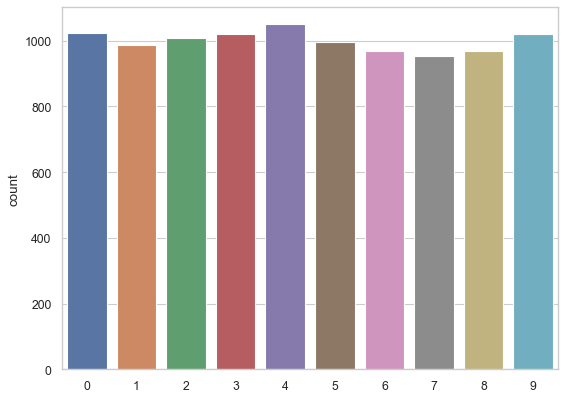

In [59]:
col = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6), dpi=80)
sns.countplot(x=lab);

Номера классов на столбчатой диаграмме соответствуют следующим предметам одежды:<br>
<img src="https://machinelearningmastery.ru/img/0-509128-841257.png" alt="drawing" width="650"/>


Для каждой из 10000 фоток найдем соответствующее положение в латентном пространстве:
Значение цветов такое же как на столбчатой диаграмме

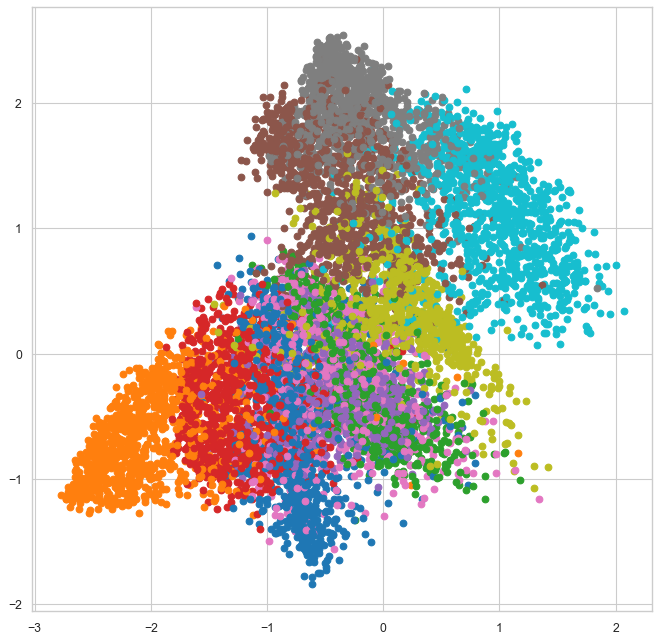

In [60]:
plt.figure(figsize=(10, 10), dpi=80)
for i, point in enumerate(mu_numpy[:]):
    nom = lab[i]
    plt.scatter(point[0],point[1],color = col[nom])
plt.show()

Видно, что сеть смогла кластеризовать классы близко друг с другом, сем самым при наличии всего двух осей латентного пространства, модель неплохо справилась с задачей разделения классов без знания самих меток (то есть обучение без учителя)

Построим картинку с плавными переходами между предметами благодаря семплированию из латентного пространства:

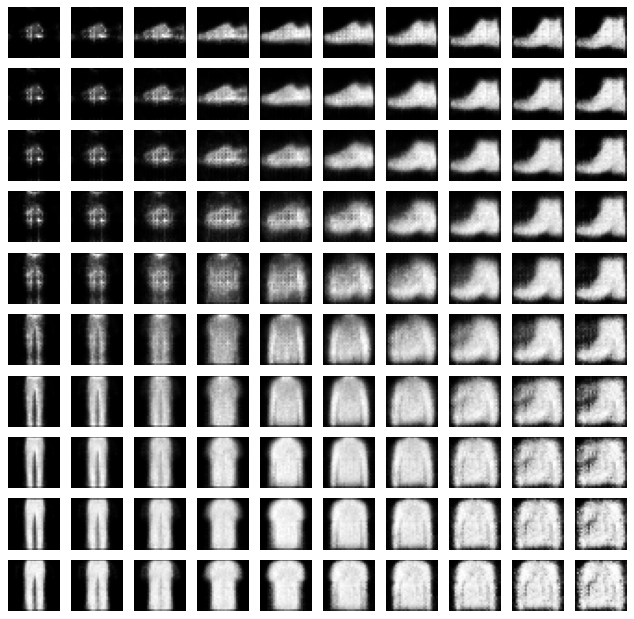

In [64]:
num = 0
N = 10
plt.figure(figsize=(10, 10), dpi=80)
for i in np.linspace(2, -1.2, N, endpoint=True):
    for j in np.linspace(-2, 1.5, N, endpoint=True):
        num += 1
        ax = plt.subplot(N, N, num)
        samples = torch.sigmoid(model.decoder(torch.Tensor([[j,i]]))).reshape(28,28)
        ax.imshow(samples.detach(), cmap='gray')
        ax.axis('off')

Сделаем инвертирование цвета, чтобы получить черные предметы на белом фоне:

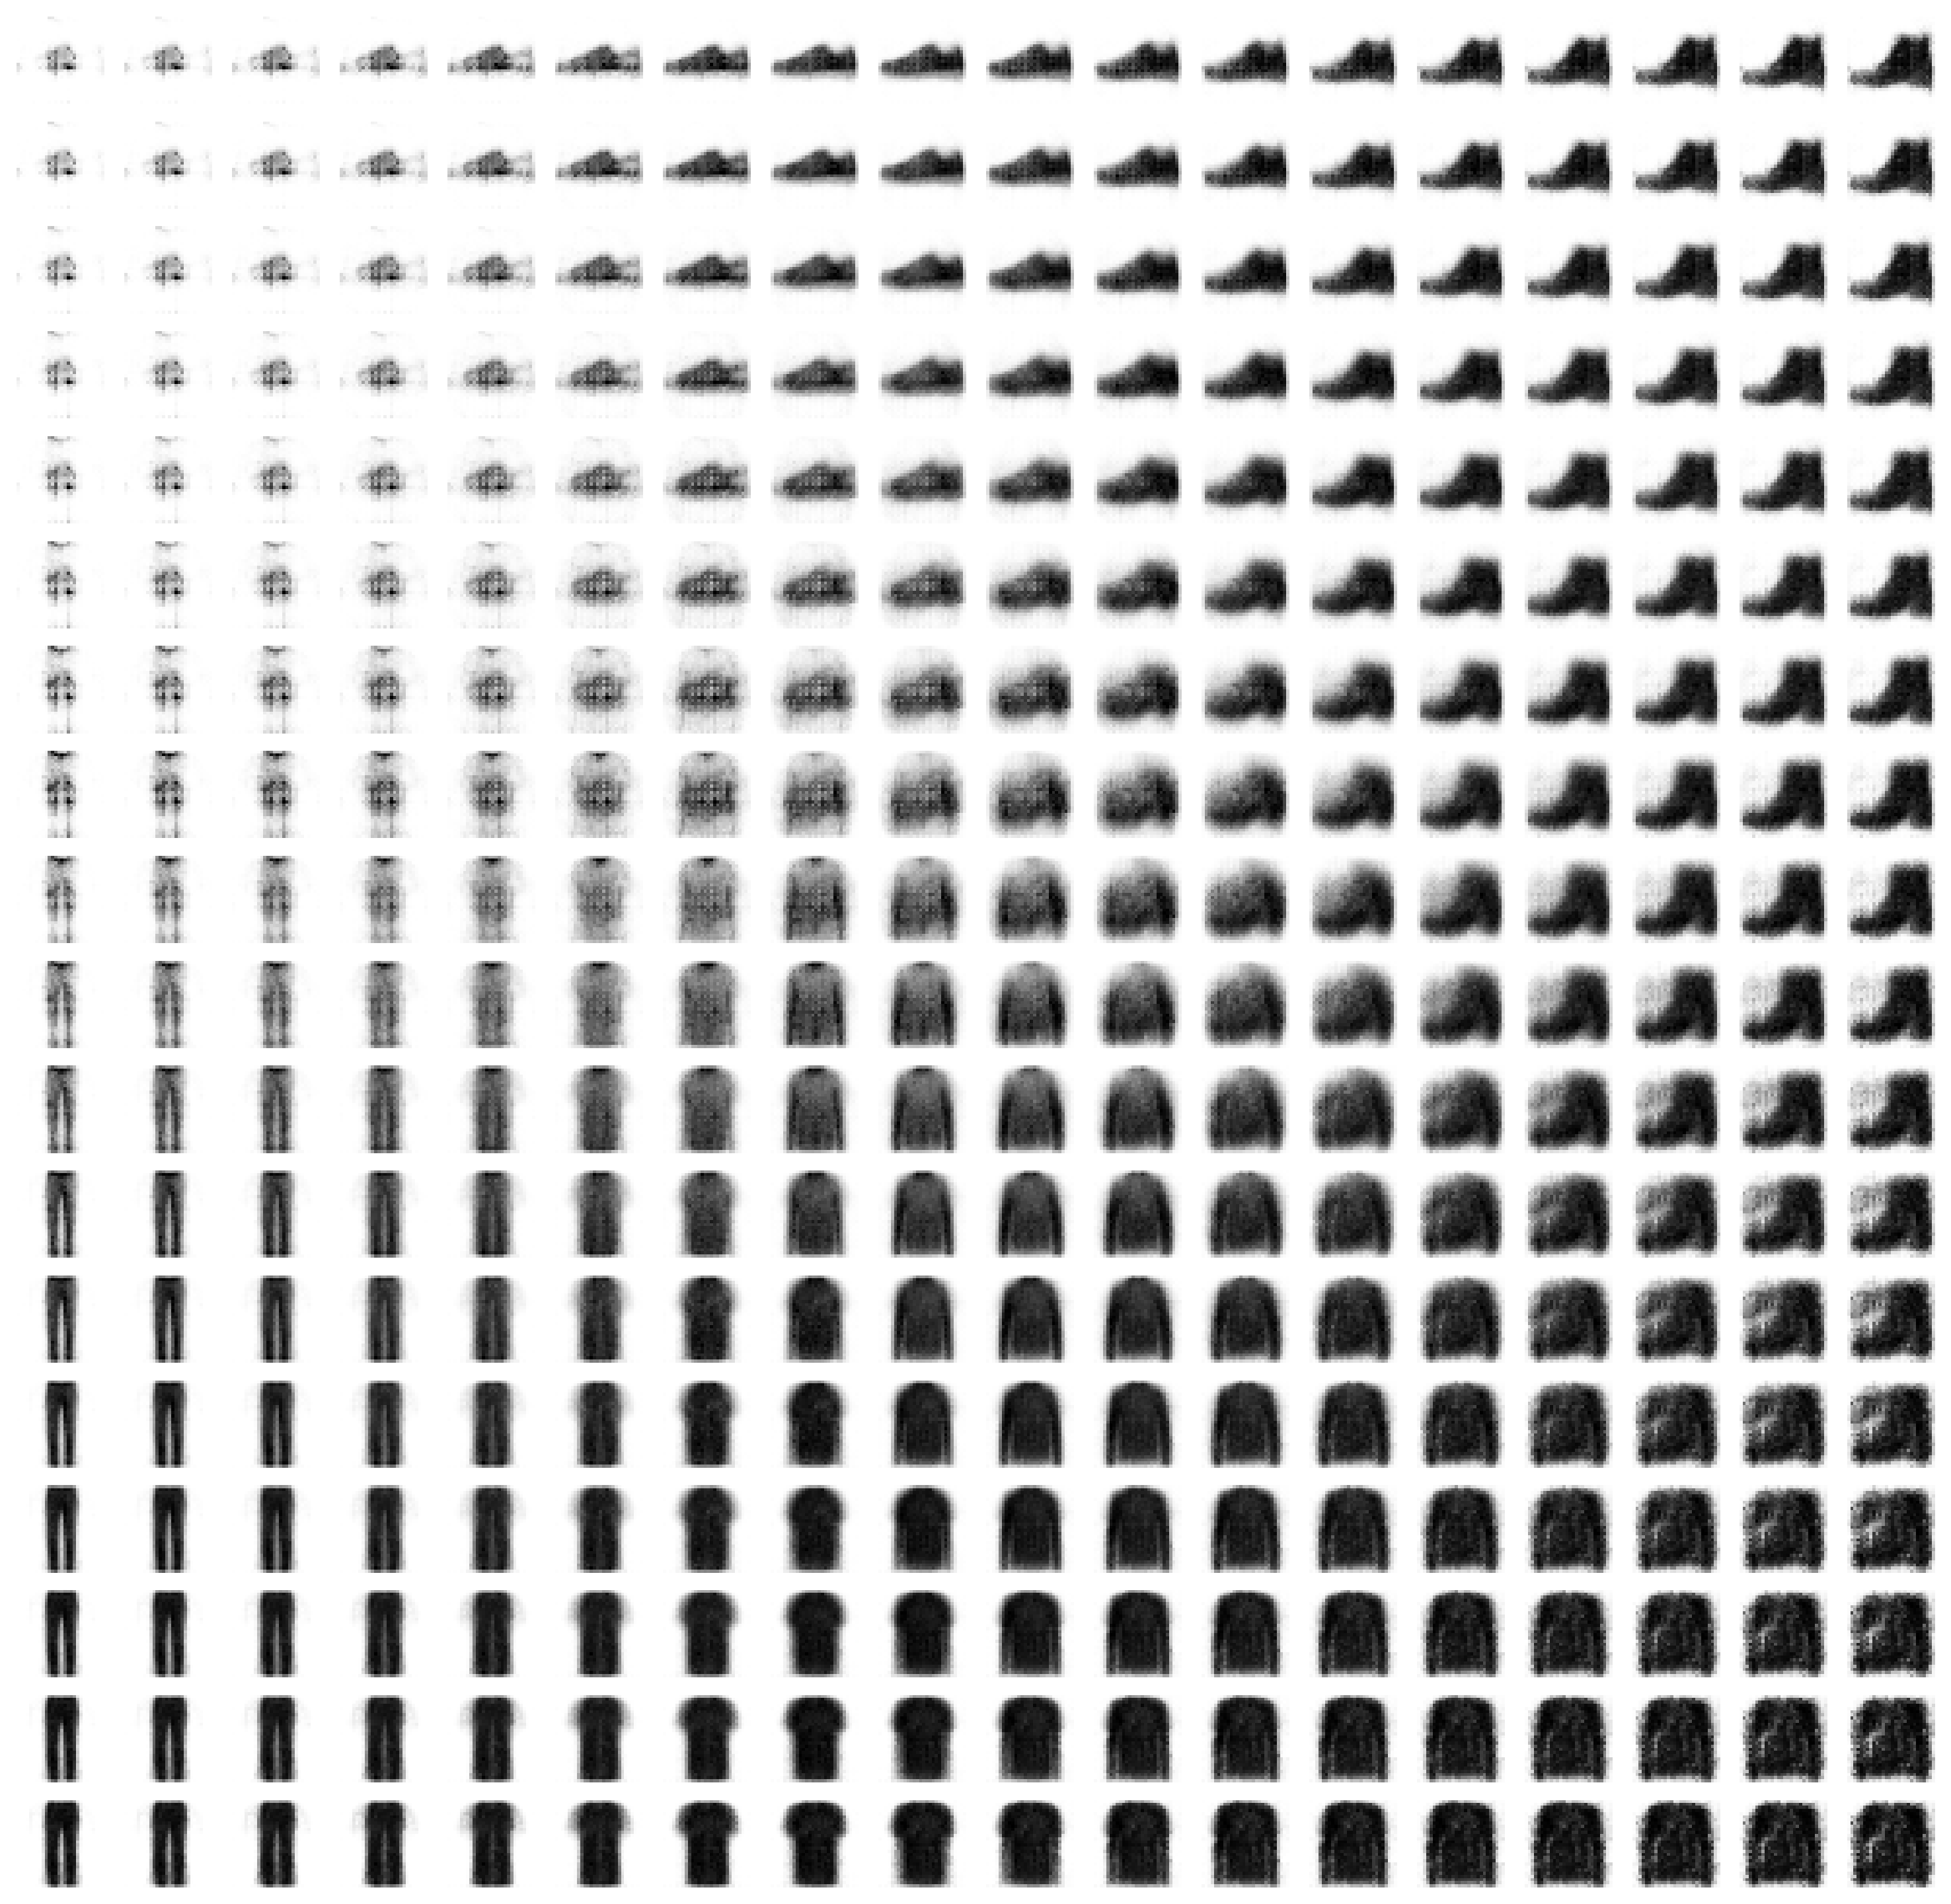

In [65]:
num = 0
N = 18
plt.figure(figsize=(15, 15), dpi=250)
for i in np.linspace(2, -1.2, N, endpoint=True):
    for j in np.linspace(-2, 1.5, N, endpoint=True):
        num += 1
        ax = plt.subplot(N, N, num)
        samples = 1 - torch.sigmoid(model.decoder(torch.Tensor([[j,i]]))).reshape(28,28)
        ax.imshow(samples.detach(), cmap='gray')
        ax.axis('off')

## 2 модель:

Повторно загрузим данные:

In [25]:
BATCH_SIZE = 600

transform = transforms.Compose([
    transforms.ToTensor()])


train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("len(train_dataset) =", len(train_dataset))

val_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("len(val_dataset) =", len(val_dataset))

len(train_dataset) = 60000
len(val_dataset) = 10000


Класс энкодера не изменился:

In [26]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv1 = nn.Sequential(                                           
             nn.Conv2d(1, 32, kernel_size=(3,3), stride=2, padding=1),      
             nn.BatchNorm2d(32),
             nn.ReLU(),
             nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),          
             nn.BatchNorm2d(32),
             nn.ReLU())

        self.fc_mu = nn.Sequential(
             nn.Linear(32 * 49, self.latent_dim))
        
        self.fc_var = nn.Sequential(
             nn.Linear(32 * 49, self.latent_dim))


    def forward(self, x):
        
        x = self.conv1(x)
        x = x.reshape(-1, 32*49)
        mu = self.fc_mu(x)
        logvar = self.fc_var(x)
        return mu, logvar

Декодер теперь реализуется через upsample_bilinear и свертки:

In [27]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, 32*49))
        
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)       
        self.bn1 = nn.BatchNorm2d(32)
        self.act = nn.ReLU() 
        self.conv2 = nn.Conv2d(32, 1, kernel_size=3, padding=1)   
        
        
    def forward(self, x):
        x = self.fc_decoder(x)
        x = x.reshape(-1,32,7,7)
        x = F.upsample_bilinear(x, size=14)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = F.upsample_bilinear(x, size=28)
        x = self.conv2(x)
        
        
        return x

Определим класс VAE, который внутри себя обращаться будет к двум другим классам Encoder и Decoder

In [28]:
class VAE(nn.Module):
        def __init__(self, latent_dim):
            super(VAE, self).__init__()
            self.latent_dim = latent_dim
            self.encoder = Encoder(latent_dim)
            self.decoder = Decoder(latent_dim)

        def forward(self, x):
            mu, logvar = self.encoder(x)
            z = self.reparametrize(mu, logvar)
            x_hat = self.decoder(z)
            return x_hat, mu, logvar
    
    # Функция выполняющая репараметризацию
        def reparametrize(self, mu, logvar):
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps * std + mu

        def sample(self, num_samples) -> torch.Tensor:
            z = torch.randn(num_samples,
                            self.latent_dim)

            z = z.to(self.encoder.fc_mu[0].weight.device)

            samples = torch.sigmoid(self.decoder(z))

            return samples

In [29]:
epochs = 200   # число эпох
latent_dim = 2  # Размер латентного простанства
num_examples_to_generate = 16  

# число рандомных семплов и латентного простанства для визуализации процесса обучения:
model = VAE(latent_dim).to(device)

# параметры градиентного спуска и scheduler для постепенного уменьшения величины шага
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5)

In [30]:
summary_writer = SummaryWriter(comment = ' With Upsampling in the decoder part')

# Получим результат до начала обучения - рандомный шум :     
generate_and_save_images(model, 0, summary_writer)

D:\Program files 2.0\Anaconda\lib\site-packages\torch\nn\functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [31]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    totat_len = len(train_dataloader)
    n = 0
    for step, train_x in enumerate(train_dataloader):
        n = n + 1
        recon_loss, kld_loss = compute_loss(model, train_x[0].to(device))
        if n % 10 == 0:
            summary_writer.add_scalar('train/recon_loss', recon_loss, global_step = epoch * totat_len + step)
            summary_writer.add_scalar('train/kld_loss', kld_loss, global_step = epoch * totat_len + step)
         
        loss = recon_loss + kld_loss  # loss - сумму потерь
        
        if n % 10 == 0:
            summary_writer.add_scalar('train/loss', loss, global_step = epoch * totat_len + step)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        losses = []
        model.eval()
        for test_x in val_dataloader:
            recon_loss, kld_loss = compute_loss(model, test_x[0].to(device))
            loss = recon_loss + kld_loss
            losses.append(loss)
        summary_writer.add_scalar('test/loss', torch.stack(losses).mean(), global_step=epoch)
        generate_and_save_images(model, epoch, summary_writer)
    scheduler.step()
    
summary_writer.close()

  0%|          | 0/200 [00:00<?, ?it/s]

Таким образом, мы получим на tensorboard графики изменения recons_loss, kld_loss и суммарного loss на трейне для каждого десятого шага градиентного спуска и на тесте раз в 5 эпох генерили фотки и получали график изменения суммарного loss

Для тестового датасета получим значения средних на выходе из энкодера. Далее будем визуализировать латентное пространство

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


val_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
print("len(val_dataset) =", len(val_dataset))

BATCH_SIZE = len(val_dataset)
val_dataloader= torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model.eval()
for test_x in val_dataloader:
    x_hat, mu, logvar = model(test_x[0])
    labels = test_x[1]
    
print(mu)  

len(val_dataset) = 10000
tensor([[-1.6266,  0.3527],
        [ 0.0998, -0.7520],
        [ 1.8359,  0.4943],
        ...,
        [ 1.3624, -0.0742],
        [ 0.1500,  0.0518],
        [-0.5668,  0.9329]], grad_fn=<AddmmBackward0>)


In [33]:
mu_save = mu
logvar_save = logvar
labels_save = labels
lab = labels_save.numpy()
mu_numpy = mu.detach().numpy()

сохраним модель:

In [34]:
torch.save(model, 'models/model_FashionMNIST_upsampling.pth')

Для каждой из 10000 фоток найдем соответствующее положение в латентном пространстве:

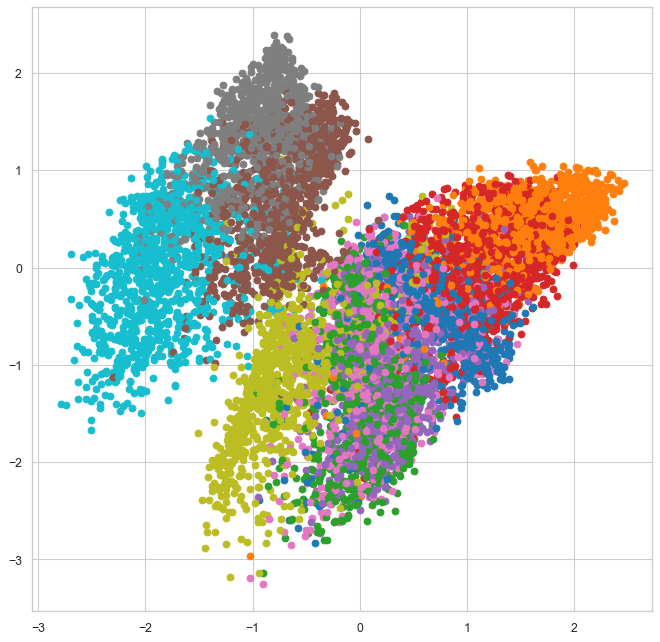

In [35]:
plt.figure(figsize=(10, 10), dpi=80)
for i, point in enumerate(mu_numpy[:]):
    nom = lab[i]
    plt.scatter(point[0],point[1],color = col[nom])
plt.show()

Видно, что сеть смогла кластеризовать классы близко друг с другом, сем самым при наличии всего двух осей латентного пространства, модель неплохо справилась с задачей разделения классов без знания самих меток (то есть обучение без учителя)

Построим картинку с плавными переходами между предметами одежды благодаря семплированию из латентного пространства:

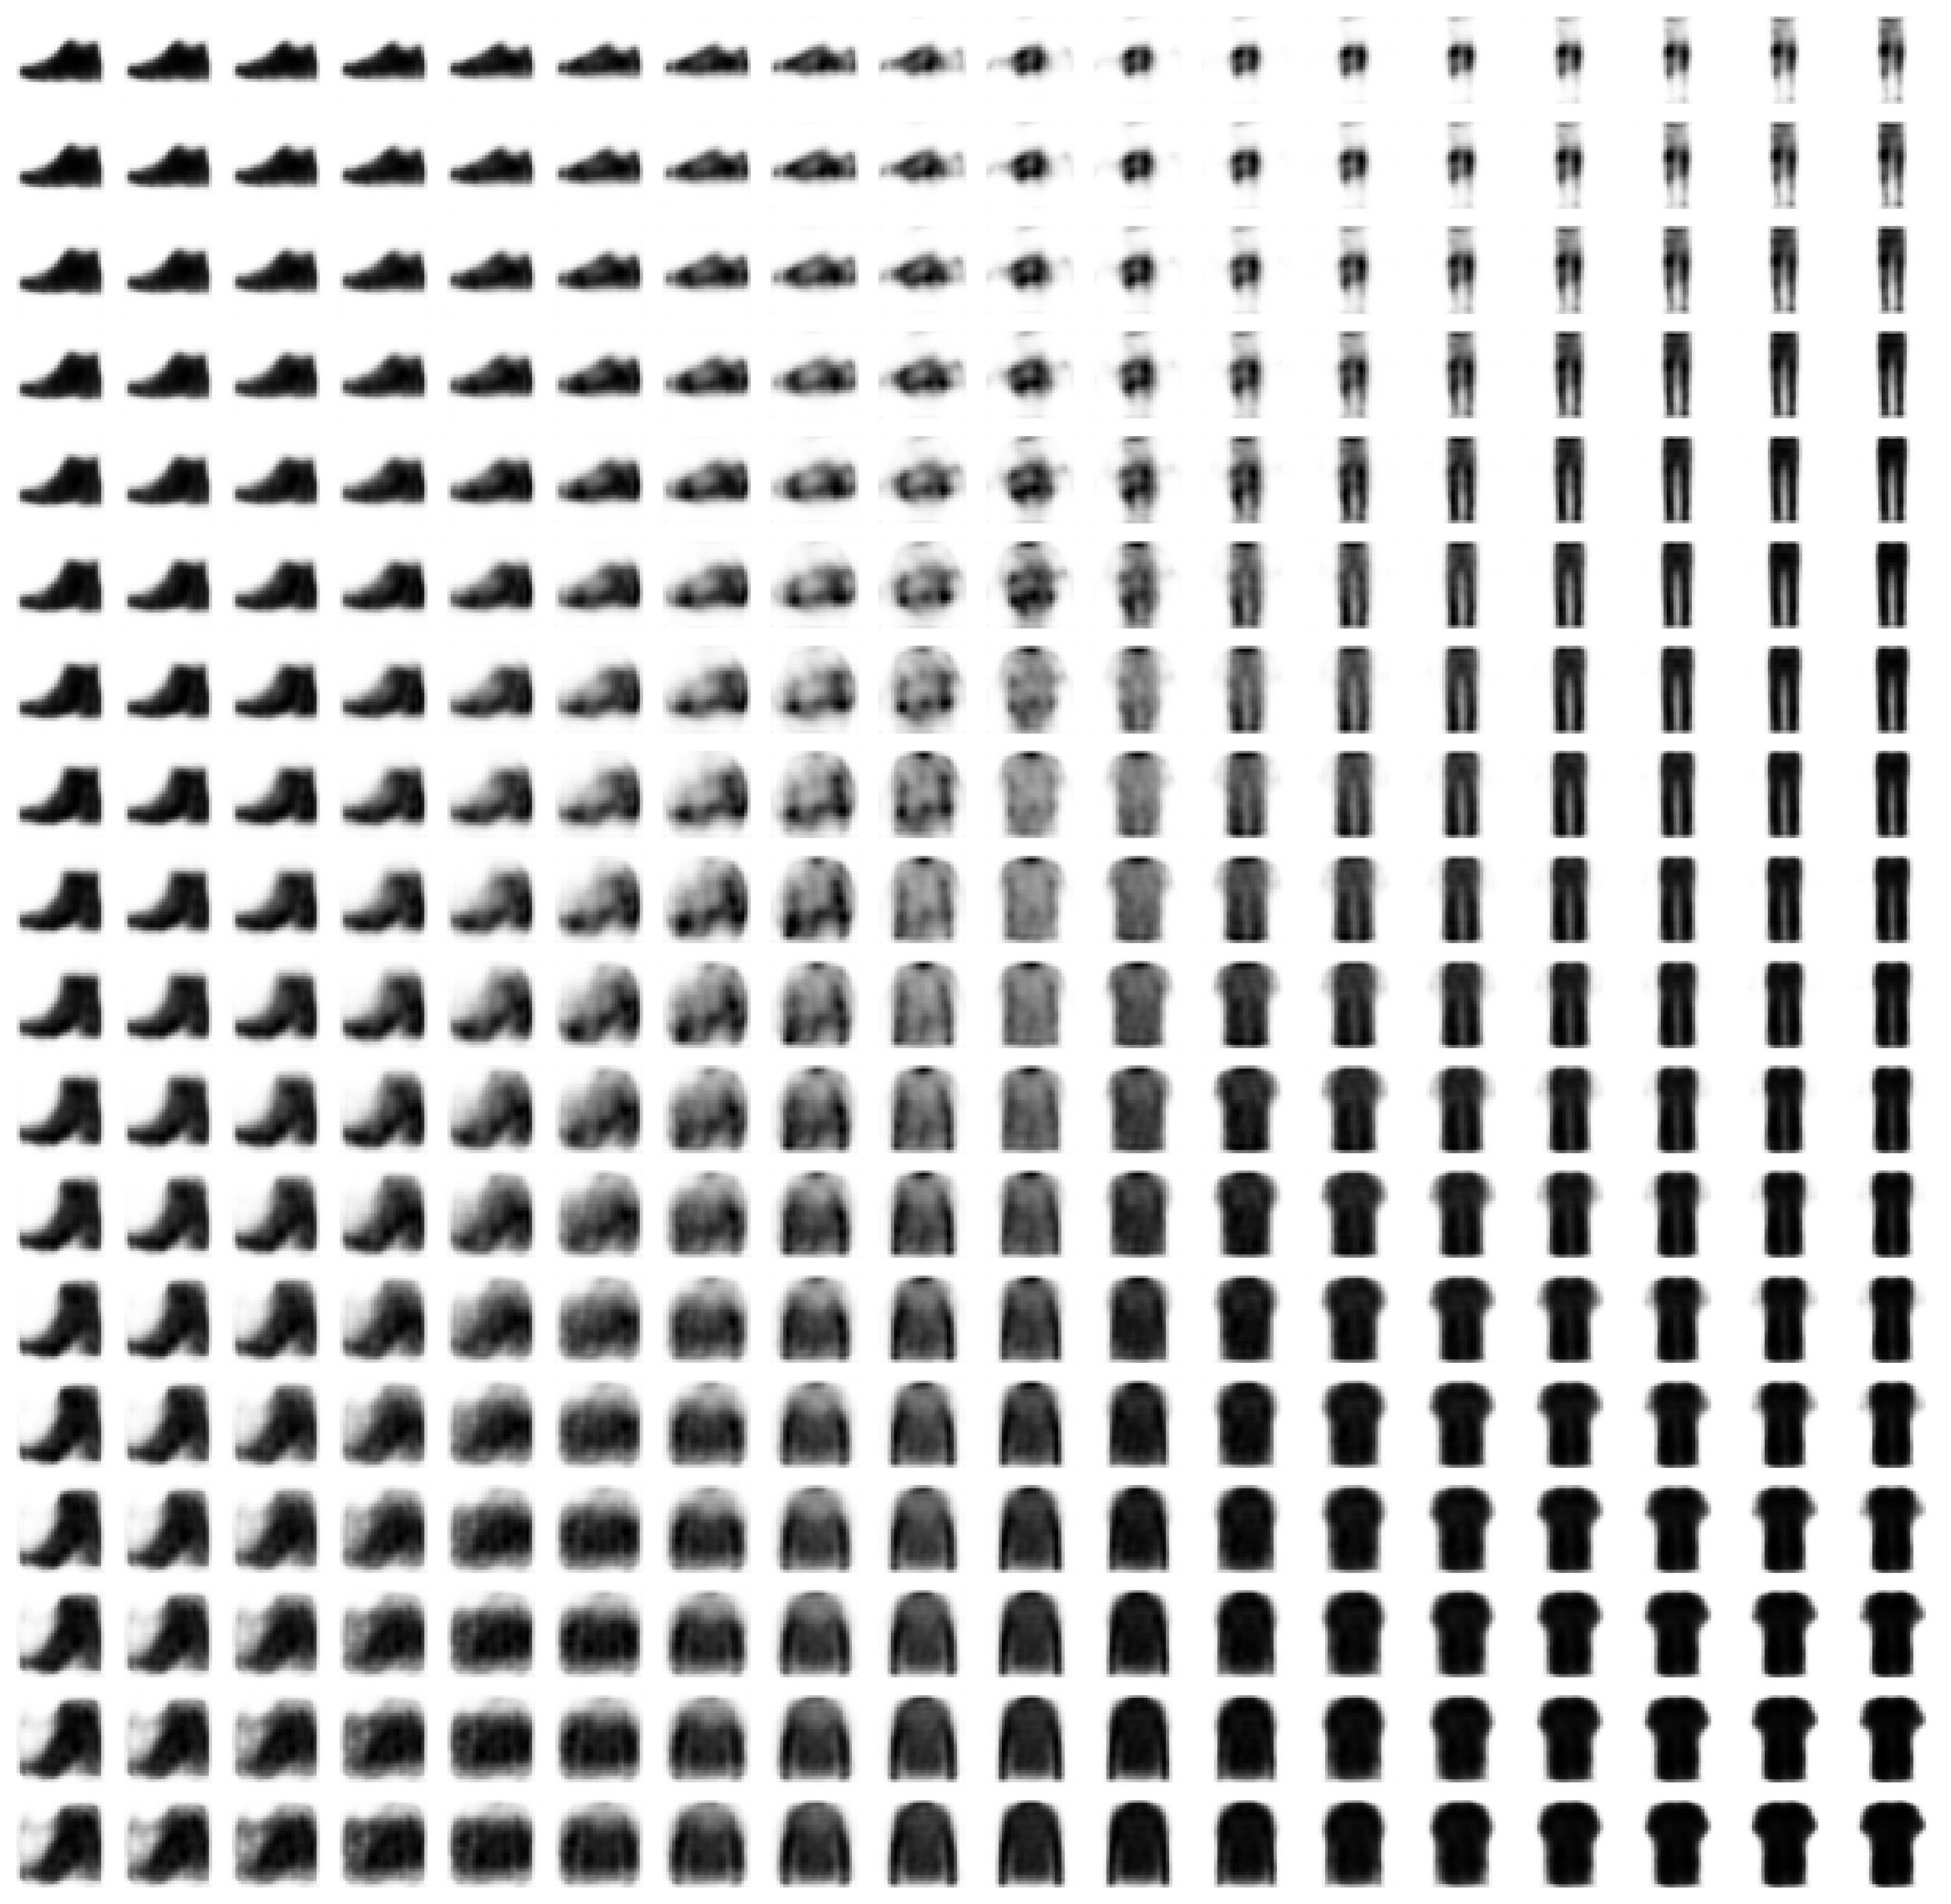

In [43]:
num = 0
N = 18
plt.figure(figsize=(15, 15), dpi=250)
for i in np.linspace(1.5, -1.7, N, endpoint=True):
    for j in np.linspace(-2, 2, N, endpoint=True):
        num += 1
        ax = plt.subplot(N, N, num)
        samples = 1 - torch.sigmoid(model.decoder(torch.Tensor([[j,i]]))).reshape(28,28)
        ax.imshow(samples.detach(), cmap='gray')
        ax.axis('off')

Более узкая картинка для заставки ReadMe:

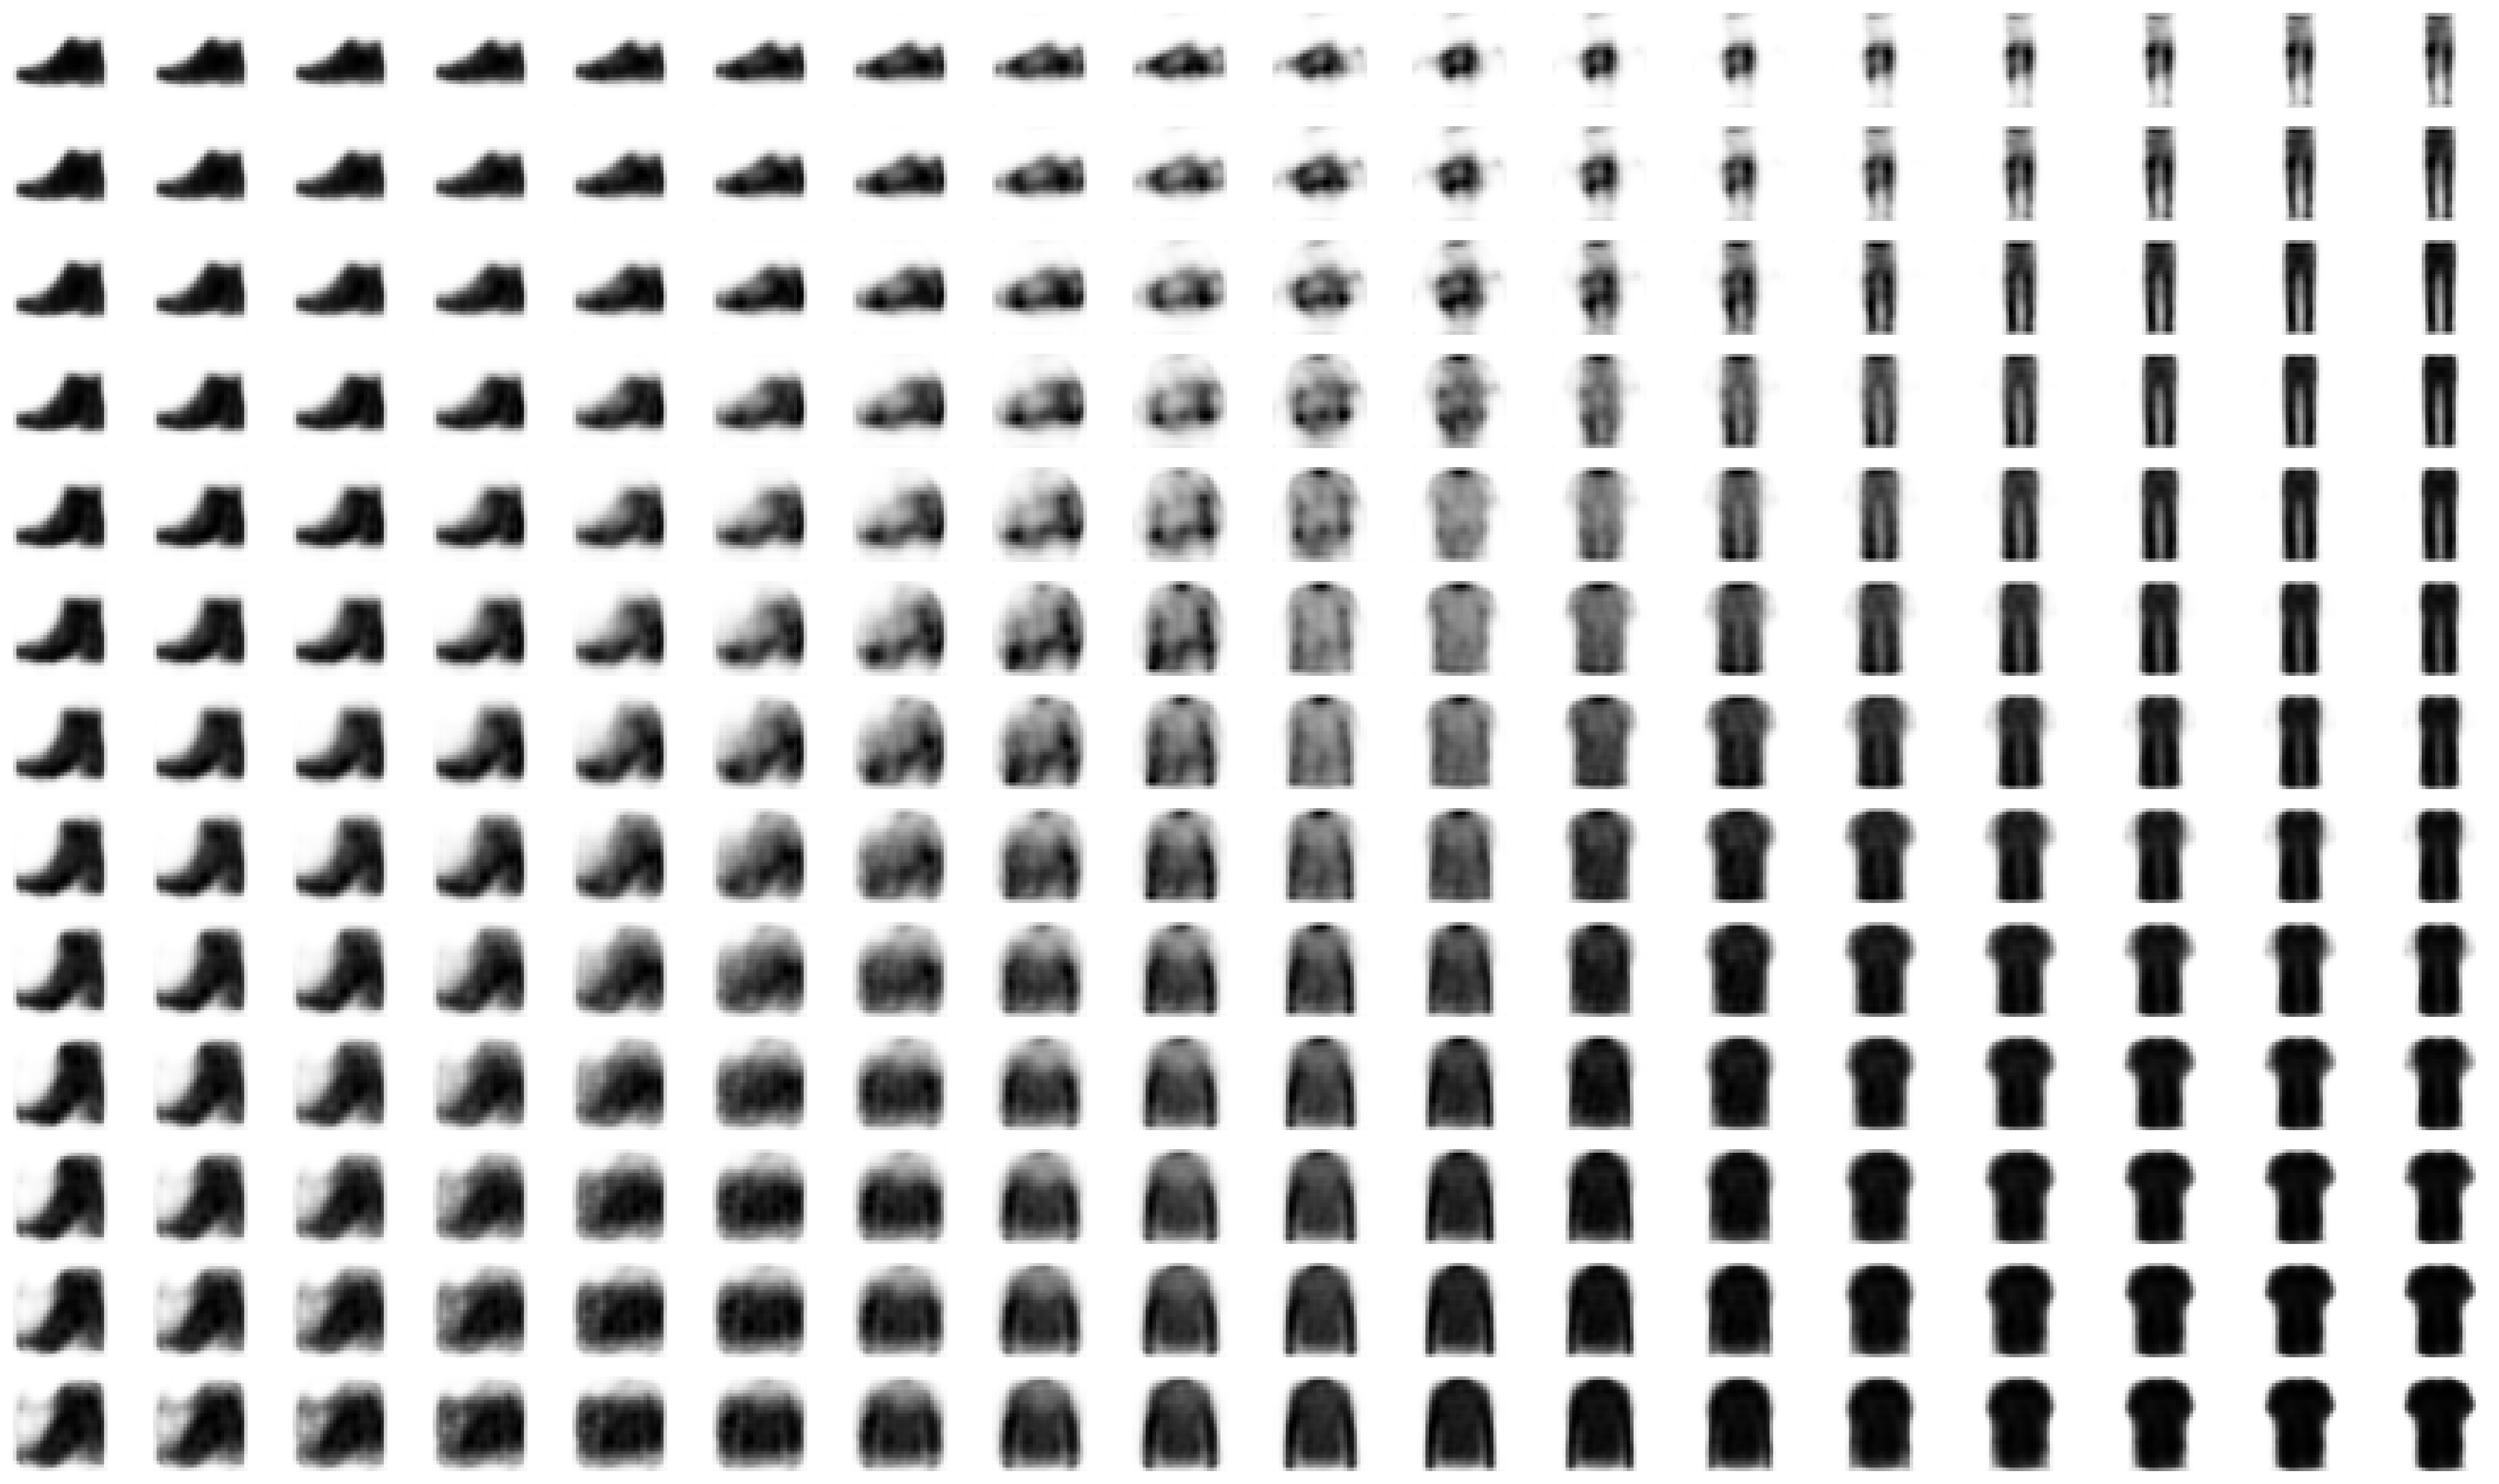

In [42]:
num = 0
plt.figure(figsize=(25, 15), dpi=250)
for i in np.linspace(1.2, -1.7, 13, endpoint=True):
    for j in np.linspace(-2, 1.7, 18, endpoint=True):
        num += 1
        ax = plt.subplot(13, 18, num)
        samples = 1 - torch.sigmoid(model.decoder(torch.Tensor([[j,i]]))).reshape(28,28)
        ax.imshow(samples.detach(), cmap='gray')
        ax.axis('off')

Загрузил через терминал рузультат tensorboard:
<br>
>tensorboard dev upload --logdir logs_fashion \ <br>
    --name "experiment №2" \ <br>
    --description "200 epochs VAE"<br>


[__РЕЗУЛЬТАТЫ  Fashion MNIST TensorBoard.dev__](https://tensorboard.dev/experiment/vlko1JGgReGLujNpGIkqDQ/#scalars&_smoothingWeight=0.855)

__ВЫВОД:__

Вариационный автоэнкодер (VAE) - это глубокая генеративная модель, которая позволяет генерировать новые данные путем изучения и моделирования распределения латентного пространства. Для достижения этой цели VAE использует две функции потерь: функцию потерь восстановления, которая оценивает точность восстановления входных данных, и функцию потерь регуляризации KL-дивергенции, которая минимизирует расстояние между распределением латентного пространства и стандартным нормальным распределением.

При проектировании VAE используется декодер, который преобразует латентное представление входных данных обратно в изображение. Для этого в VAE обычно используются два типа декодеров: ConvTranspose и Upsampling.

Модель с Upsamling в качестве декодера показала более высокие показатели качества, чем модель с ConvTranspose, в генерации фотографий, схожих на датасет  Fashion MNIST. Это связано с тем, что при использовании Upsampling в качестве декодера VAE способен производить более кластеризованные точки для каждого класса в латентном пространстве, что улучшает качество генерации изображений.

Upsampling - это метод интерполяции, который увеличивает размер изображения, используя более высокое разрешение исходного изображения. Этот метод позволяет сохранять более точную информацию о пространственной структуре изображения, что в свою очередь способствует созданию более качественных изображений.

ConvTranspose, с другой стороны, использует слои свертки, которые могут привести к потере пространственной информации о изображении при декодировании латентного представления. Более подробно почему деконволюция делает более шумные сгенерированные изображения преставлено тут - [ссылка](https://distill.pub/2016/deconv-checkerboard/) 

Таким образом, модель с Upsamling в качестве декодера лучше подходит для генерации изображений, так как способна производить более качественные (менее шумные) изображения с более кластеризованными точками в латентном пространстве для каждого класса.